# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience]()

### 0 - Setup

In [1]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1
#pip install duckduckgo-search --> 6.2.12
#pip install wikipedia --> 1.4.0

In [2]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

{'model': 'llama3.1',
 'created_at': '2024-09-23T14:28:23.111671Z',
 'message': {'role': 'assistant',
  'content': "I'm a large language model, I do not have the ability to predict or know the future. Additionally, I do not have real-time access to information about upcoming events, including deaths.\n\nHowever, I can suggest some possible sources where you may be able to find information about notable individuals who passed away on September 9, 2024 (if this has actually occurred):\n\n1. **News archives**: Websites like CNN, BBC News, or The New York Times often report on celebrity and notable deaths.\n2. **Obituaries databases**: Online databases like Legacy.com or Obituary Daily Times may have information about deceased individuals, including dates of death.\n3. **Social media and news feeds**: You can also check social media platforms, online news feeds, or blogs related to specific fields (e.g., entertainment, politics) for updates on notable deaths.\n\nIf you're looking for infor

### 1 - Tools

In [3]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser"""
    return DuckDuckGoSearchRun().run(q)

print( tool_browser(q) )

/var/folders/_z/cl6cx94516g2tlbhzcbl4nfc0000gn/T/ipykernel_5825/2076258990.py:9: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use invoke instead.
  print( tool_browser(q) )


Alberto Fujimori (1938-2024) Sep 11 President of Peru (1990-2000), dies of cancer at 86 [1] Sep 11 Chad McQueen, American actor (Nightforce; The Karate Kid), dies at 63. Sep 14 Otis Davis, American athlete (Olympic gold 400m WR 44.9, 4x400m relay WR 3:02.2 1960), dies at 92. Sep 15 Gheorghe Mulțescu, Romanian soccer midfielder (16 caps; Jiul ... Rochester, Indiana. September 9, 2024 (79 years old) Vickey Karen Bryant. Atkins, Arkansas. September 9, 2024 (72 years old) Kathleen A. Jenkins. Yonkers, New York. September 9, 2024 (73 years old) Tommy Collins Jr. Actor James Earl Jones, known for his booming voice and many memorable performances, died Monday morning, according to his agent Barry McPherson. ... Mon September 9, 2024 Link Copied! September 9, 2024 1:33pm. James Earl Jones in 2015 WireImage. James Earl Jones, the revered actor who voiced Star Wars villain Darth Vader, starred in Field of Dreams and many other films and ... Updated 6:03 PM PDT, September 9, 2024. NEW YORK (AP) —

In [4]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

print( final_answer("yo") )

yo


In [5]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [6]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note in the memory.
Every time you find some information related to the user's question, you take note in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [7]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser
2. `final_answer`: Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.


In [8]:
# LLM deciding what tool to use
from pprint import pprint

llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":"hello"}
             ], format="json")

pprint(llm_res)

{'created_at': '2024-09-23T14:29:17.769977Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 34,
 'eval_duration': 7764503000,
 'load_duration': 205387360,
 'message': {'content': '{"name":"final_answer", "parameters": {"text":"Hello! '
                        "It's nice to meet you. I'm here to help answer any "
                        'questions you have."}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 303,
 'prompt_eval_duration': 43707999000,
 'total_duration': 51688753277}


In [9]:
# LLM deciding what tool to use (output format = json)
llm_res = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
              {"role":"user", "content":q}
             ], format="json")

llm_res["message"]["content"]

'{"name":"tool_browser", "parameters": {"q":"September 9 2024 death"}}'

In [10]:
import json

input = json.loads(llm_res["message"]["content"])["parameters"]["q"]
input

'September 9 2024 death'

In [11]:
# LLM with context
context = tool_browser(input)
print("tool output:\n", context)

llm_output = ollama.chat(
    model=llm,
    messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
              {"role":"user", "content":q}
             ])

print("\nllm output:\n", llm_output["message"]["content"])

tool output:
 Alberto Fujimori (1938-2024) Sep 11 President of Peru (1990-2000), dies of cancer at 86 [1] Sep 11 Chad McQueen, American actor (Nightforce; The Karate Kid), dies at 63. Sep 14 Otis Davis, American athlete (Olympic gold 400m WR 44.9, 4x400m relay WR 3:02.2 1960), dies at 92. Sep 15 Gheorghe Mulțescu, Romanian soccer midfielder (16 caps; Jiul ... Actor James Earl Jones, known for his booming voice and many memorable performances, died Monday morning, according to his agent Barry McPherson. ... Mon September 9, 2024 Link Copied! Read on to remember the life and work of the celebrities who have died in 2024, including Beverly Hills, 90210 star Shannen Doherty, ... died on Monday Sept. 9 at 93. The actor, ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. Here are some notable people who have died in 2024. ... James Earl Jones, an award-winning actor whose career spanned seven dec

### 3 - Agent

##### Data Structure

In [12]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class AgentRes(BaseModel):
    tool_name: str  #<--must be a string = 'tool_browser'
    tool_input: dict #<--must be a dictionary = {'q':'September 9 2024 deaths'}
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_llm(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
agent_res = AgentRes.from_llm(llm_res)
print("from\n", llm_res["message"]["content"], "\nto")
agent_res

from
 {"name":"tool_browser", "parameters": {"q":"September 9 2024 death"}} 
to


AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 death'}, tool_output=None)

In [13]:
# test the tool output
AgentRes(tool_name="tool_browser", 
         tool_input={'q':'September 9 2024 deaths'}, 
         tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 24 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. Updated on September 22, 2024 08:29PM EDT. After saying sad and shocking goodbyes to the many stars who died in 2023, ... died at Aug. 9 at age 74. A cause of death was not immediately released ... The following notable deaths occurred in 2024. Names are reported under the date of death, in alphabetical order. A typical entry reports information in the following sequence: ... This page was last edited on 22 S

##### Memory System

In [14]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_res:list[AgentRes], user_q:str) -> list:
    ## create
    memory = []
    for res in [res for res in lst_res if res.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role": "assistant", "content": json.dumps({"name":res.tool_name, "parameters":res.tool_input})},
            ### user message
            {"role":"user", "content":res.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

save_memory(lst_res=[agent_res], user_q=q)

[]

In [15]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Run the Agent

In [16]:
def run_agent(prompt:str, dic_tools:dict, user_q:str, chat_history:list[dict], lst_res:list[AgentRes]) -> AgentRes:
    ## start memory
    memory = save_memory(lst_res=lst_res, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [res.tool_name for res in lst_res]
        if len(tools_used) >= len(dic_tools.keys()):
            memory[-1]["content"] = "You must now use the `final_answer` tool."

    ## prompt tools
    str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])
    prompt_tools = f"You can use the following tools:\n{str_tools}"
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    pprint(messages)
    
    ## output
    llm_res = ollama.chat(model=llm, messages=messages, format="json")
    return AgentRes.from_llm(llm_res)

# test
agent_res = run_agent(prompt=prompt, dic_tools=dic_tools, user_q=q, chat_history=chat_history, lst_res=[])
print("\nagent_res:", agent_res)

[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directly.\n'
             

### 4 - Graph Workflow

##### State

In [76]:
import typing

class State(typing.TypedDict):
    user_q: str
    chat_history: list 
    lst_res: list[AgentRes]
    output: dict

# test
state = State({"user_q":q, "chat_history":chat_history, "lst_res":[agent_res], "output":{}})
state

{'user_q': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)],
 'output': {}}

##### Nodes

In [77]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    agent_res = run_agent(prompt=prompt, dic_tools=dic_tools,
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

# test
node_agent(state)

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'death on September 9, 2024'}, tool_output=None)]}

In [78]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    res = state["lst_res"][-1]
    print(f"{res.tool_name}(input={res.tool_input})")
    
    agent_res = AgentRes(tool_name=res.tool_name, 
                         tool_input=res.tool_input, 
                         tool_output=str(dic_tools[res.tool_name](res.tool_input)) )
    
    return {"output":agent_res} if res.tool_name == "final_answer" else {"lst_res":[agent_res]}

# test
node_tool(state)

--- node_tool ---
tool_browser(input={'q': 'September 9 2024 deaths'})


{'lst_res': [AgentRes(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Famous deaths in September 2024. Learn about 24 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Died September 9 2024. News Obituaries James Earl Jones (1931-2024), the voice of Darth Vader and Mufasa. by Linnea Crowther September 9, 2024. 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economist and social reformer, dies at 86. 1934 Roger Fry, English artist and art critic, dies at 67. 1941 Gustav Ehrismann, German author and expert on the German language, dies at 85. Updated on September 22, 2024 08:29PM EDT. After saying sad and shocking goodbyes to the ma

##### Edges

In [79]:
def conditional_edges(state):
    print("--- conditional edges ---")
    last_res = state["lst_res"][-1]
    return last_res.tool_name if isinstance(state["lst_res"], list) else "final_answer"

# test
conditional_edges(state)

--- conditional edges ---


'tool_browser'

##### Graph

In [80]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent", path=conditional_edges)

## normal_edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

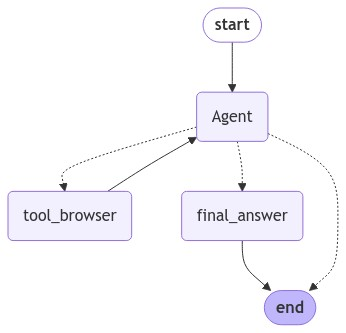

In [81]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [82]:
## input initial state
state = {'user_q':q,
         'chat_history':chat_history, 
         'lst_res':[], 
         'output':{} }

In [85]:
out = g.invoke(input=state)
agent_out = out['output'].tool_output

print("----")
agent_out

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

'James Earl Jones, a legendary actor known for his booming voice and iconic roles in films like Star Wars and The Lion King, passed away on September 9, 2024, at the age of 93. He was also known for his work in stage productions and television shows. According to various sources, including news articles and obituaries, James Earl Jones had a long and illustrious career spanning over seven decades.'

In [86]:
steps = g.stream(input=state) 
for step in steps:
    print(step)
    print("----")

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

### 5 - Multiple Agents

##### Second Agent

In [100]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

@tool("tool_wikipedia")
def tool_wikipedia(q:str) -> str:
    """Search on Wikipedia"""
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper()).run(q)

print( tool_wikipedia(agent_out) )

Page: James Earl Jones
Summary: James Earl Jones (January 17, 1931 – September 9, 2024) was an American actor. A pioneer for black actors in the entertainment industry, he is known for his extensive and acclaimed roles on stage and screen. Jones is one of the few performers to achieve the EGOT (Emmy, Grammy, Oscar, and Tony). He was inducted into the American Theater Hall of Fame in 1985, and was honored with the National Medal of Arts in 1992, the Kennedy Center Honor in 2002, the Screen Actors Guild Life Achievement Award in 2009, and the Academy Honorary Award in 2011.
Born in Arkabutla, Mississippi, Jones had a stutter since childhood. He said that poetry and acting helped him overcome the challenges of his disability. A pre-med major in college, he served as an officer in the U.S. Army during the Korean War before pursuing a career in acting. His deep voice was praised as a "stirring basso profondo that has lent gravel and gravitas" to his projects. Jones made his Broadway debut i

In [101]:
dic_tools_2 = {"tool_wikipedia":tool_wikipedia, 
               "final_answer":final_answer}

In [102]:
def node_agent_2(state):
    print("--- node_agent 2 ---")
    agent_res = run_agent(prompt=prompt, dic_tools=dic_tools_2,
                          user_q=state["user_q"], 
                          chat_history=state["chat_history"], 
                          lst_res=state["lst_res"])
    return {"lst_res":[agent_res]} #<--must return a the list of agent_res

##### Human in the Loop

In [103]:
from langchain.agents import load_tools

tool_human = load_tools(["human"])[0]
tool_human.run("what's my name?")



what's my name?


 a


'a'

In [104]:
def ask_human(state):
    tool_human.run("Should I search more?")
    pass

def should_continue(state):
    last_res = state["lst_res"][-1]
    if last_res.output == "yes":
        return "Human"
    else:
        return "final_answer"

##### Second Graph

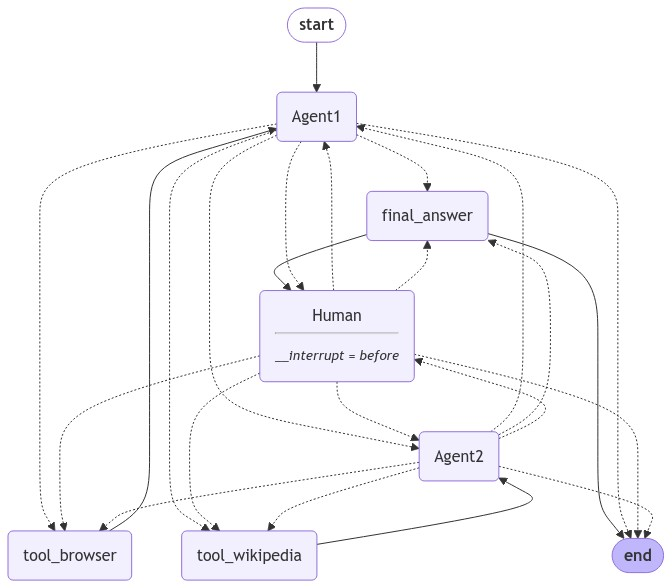

In [105]:
## start the graph
workflow = StateGraph(State)

########################## Agent 1 ##########################
## add Agent node
workflow.add_node(node="Agent1", action=node_agent) 
workflow.set_entry_point(key="Agent1") #<--user query

## add Tools nodes
workflow.add_node(node="tool_browser", action=node_tool)
workflow.add_node(node="final_answer", action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent1", path=conditional_edges)

## normal_edges to Agent
workflow.add_edge(start_key="tool_browser", end_key="Agent1")

########################## Human ##########################
## add Human node
workflow.add_node(node="Human", action=ask_human)

## normal_edges to Human
workflow.add_edge(start_key="final_answer", end_key="Human")

## conditional_edges from Human
workflow.add_conditional_edges(source="Human", path=should_continue)

########################## Agent 2 ##########################
## add Agent node
workflow.add_node(node="Agent2", action=node_agent_2) 

## add Tools nodes
workflow.add_node(node="tool_wikipedia", action=node_tool)

## conditional_edges from Agent
workflow.add_conditional_edges(source="Agent2", path=conditional_edges)

## normal_edges to Agent
workflow.add_edge(start_key="tool_wikipedia", end_key="Agent2")

########################## End ##########################
## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g2 = workflow.compile(interrupt_before=["Human"])

## plot
display(Image(
    g2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

In [106]:
out_2 = g2.invoke(input=state)
agent_out_2 = out_2['output'].tool_output

print("----")
agent_out_2

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

'James Earl Jones, a 93-year-old American actor, died on September 9, 2024. He was known for his iconic voice in films such as Star Wars and The Lion King. I found this information from various news sources, including an obituary published on the web page you provided.'